## PRQL - A Modern Language For Transforming Data

### Tobias Brandt (twitter.com/T0bias_Brandt)

### https://github.com/snth/normconf2022

<img src="NormConf_Logo.png" width="240" align="middle"/> 

### https://prql-lang.org/

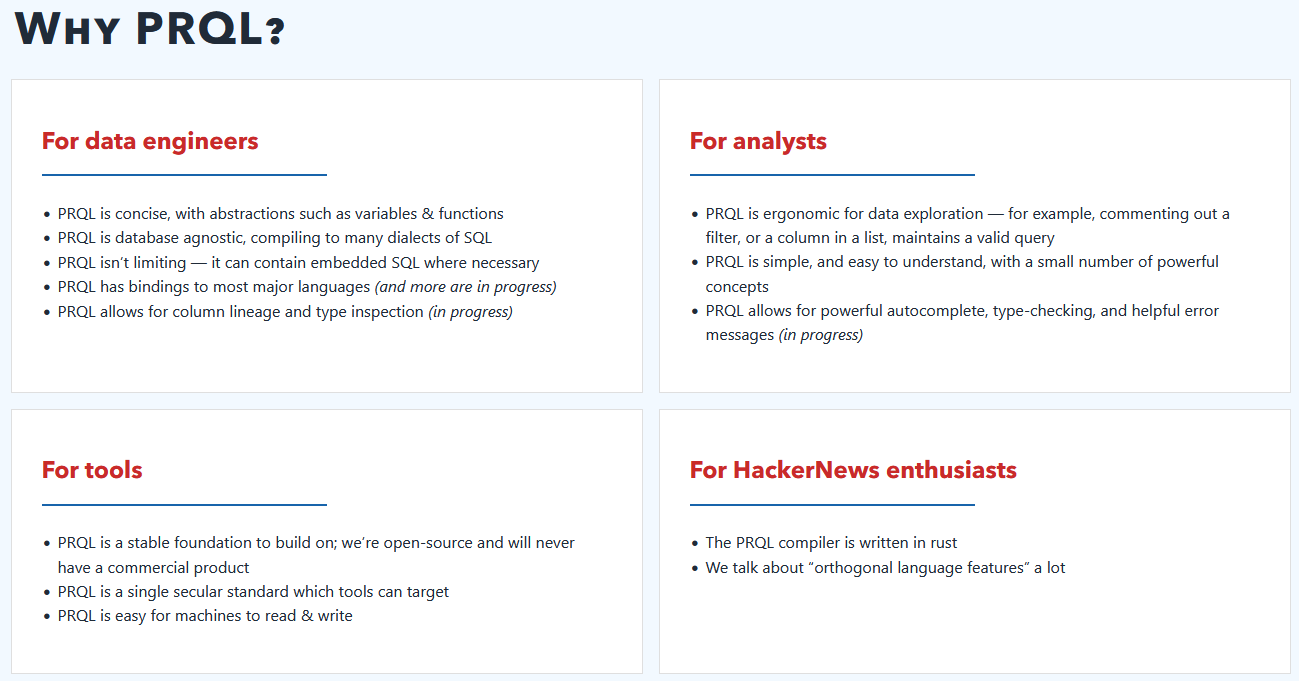

## PRQL transpiles to SQL

You can do this in your browser, go to [https://prql-lang.org/playground/](https://prql-lang.org/playground/) now!

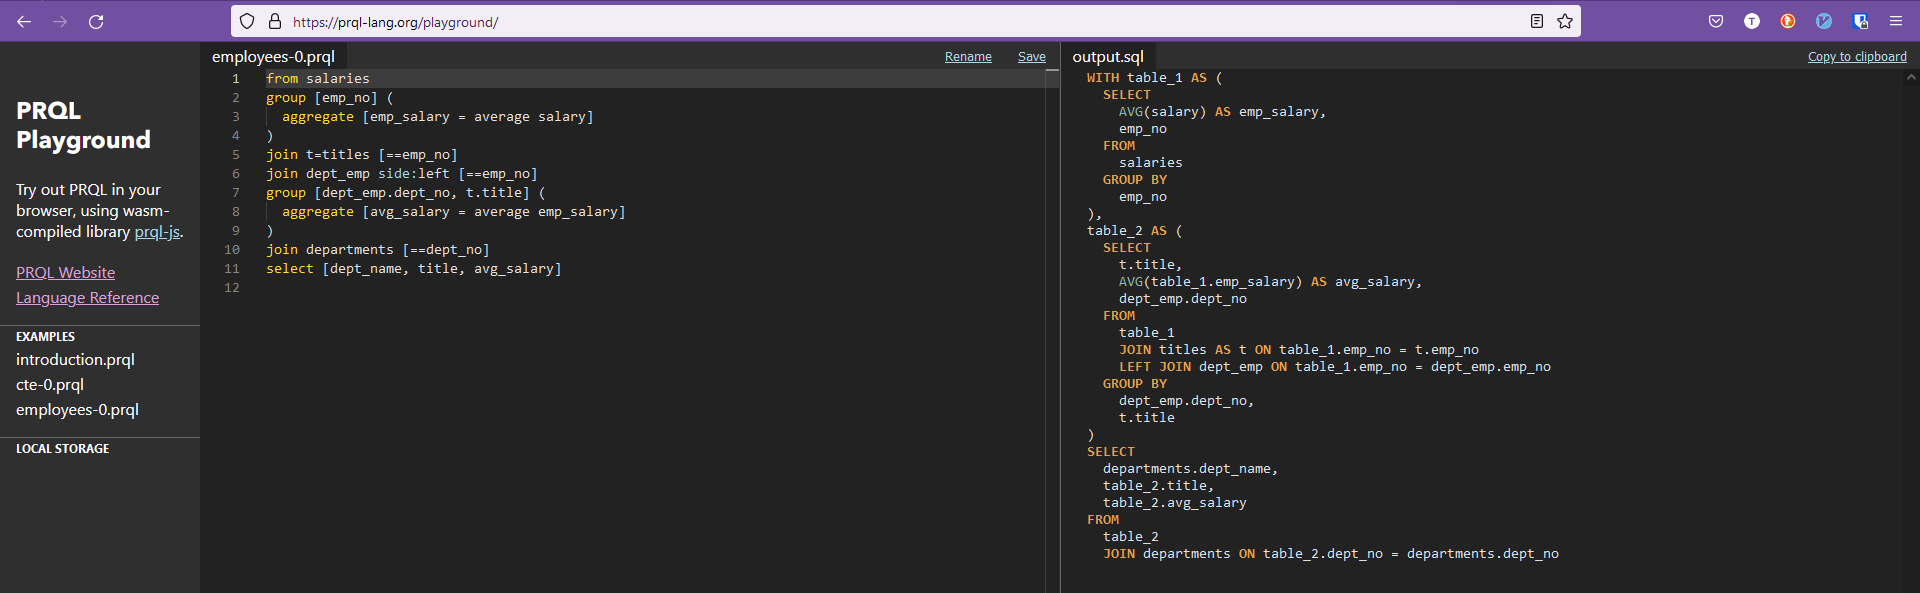

## Python

In [1]:
!pip install prql-python

In [2]:
import prql_python as prql

prql_query = """
    from employees
    join salaries [==emp_id]
    group [dept_id, gender] (
        aggregate [
            avg_salary = average salary
        ]
    )
"""

sql = prql.to_sql(prql_query)
print(sql)

SELECT
  dept_id,
  gender,
  AVG(salary) AS avg_salary
FROM
  employees
  JOIN salaries ON employees.emp_id = salaries.emp_id
GROUP BY
  dept_id,
  gender


In [3]:
# Say we want the top 5 salaries by department instead
prql_query = """
    from employees
    join salaries [==emp_id]
    group [dept_id] (
        sort [-salary]
        take 5
    )
"""

sql = prql.to_sql(prql_query)
print(sql)

WITH table_1 AS (
  SELECT
    employees.*,
    salaries.*,
    ROW_NUMBER() OVER (
      PARTITION BY dept_id
      ORDER BY
        salary DESC
    ) AS _expr_0
  FROM
    employees
    JOIN salaries ON employees.emp_id = salaries.emp_id
)
SELECT
  *,
  *
FROM
  table_1
WHERE
  _expr_0 <= 5


## Pandas and Jupyter Magics

In [14]:
!pip install pyprql

In [26]:
import pandas as pd
import pyprql.pandas_accessor

df = pd.read_csv("data/customers.csv")
df.prql.query('filter country=="Germany"')

,customer_id,first_name,last_name,company,address,city,state,country,postal_code,phone,fax,email,support_rep_id
0,2,Leonie,Köhler,NaN,Theodor-Heuss-Straße 34,Stuttgart,NaN,Germany,70174,+49 0711 2842222,NaN,leonekohler@surfeu.de,5
1,36,Hannah,Schneider,NaN,Tauentzienstraße 8,Berlin,NaN,Germany,10789,+49 030 26550280,NaN,hannah.schneider@yahoo.de,5
2,37,Fynn,Zimmermann,NaN,Berger Straße 10,Frankfurt,NaN,Germany,60316,+49 069 40598889,NaN,fzimmermann@yahoo.de,3
3,38,Niklas,Schröder,NaN,Barbarossastraße 19,Berlin,NaN,Germany,10779,+49 030 2141444,NaN,nschroder@surfeu.de,3


In [28]:
%load_ext pyprql.magic

In [31]:
%%prql duckdb:///:memory:
from `data/invoices.csv`
filter billing_country=='USA'
sort [-total]
take 5

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
0,299,26,2012-08-05,2211 W Berry Street,Fort Worth,TX,USA,76110,23.86
1,201,25,2011-05-29,319 N. Frances Street,Madison,WI,USA,53703,18.86
2,103,24,2010-03-21,162 E Superior Street,Chicago,IL,USA,60611,15.86
3,5,23,2009-01-11,69 Salem Street,Boston,MA,USA,2113,13.86
4,26,19,2009-04-14,1 Infinite Loop,Cupertino,CA,USA,95014,13.86


## Shell

### prql-query (`pq`)

### https://github.com/prql/prql-query

In [10]:
!wget https://github.com/prql/prql-query/releases/download/v0.0.14/pq-x86_64-unknown-linux-gnu.tar.gz \
    && tar xvzf pq-x86_64-unknown-linux-gnu.tar.gz \
    && rm pq-x86_64-unknown-linux-gnu.tar.gz

In [23]:
%%bash
./pq --from data/invoices.csv <<EOF
group [customer_id] (
    aggregate [customer_total = sum total]
)
sort [-customer_total]
take 5
EOF

---
+-------------+--------------------+
| customer_id | customer_total     |
+-------------+--------------------+
| 6           | 49.620000000000005 |
| 26          | 47.620000000000005 |
| 57          | 46.62              |
| 46          | 45.62              |
| 45          | 45.62              |
+-------------+--------------------+


In [11]:
%%bash
./pq --from i=data/invoices.csv --from c=data/customers.csv <<EOF
from i
group [customer_id] (
    aggregate [customer_total = sum total]
)
sort [-customer_total]
take 5
join c [customer_id]
select [customer_name=f'{first_name} {last_name}', customer_total]
EOF

---
+--------------------+--------------------+
| customer_name      | customer_total     |
+--------------------+--------------------+
| Richard Cunningham | 47.620000000000005 |
| Hugh O'Reilly      | 45.62              |
| Helena Holý        | 49.620000000000005 |
| Ladislav Kovács    | 45.62              |
| Luis Rojas         | 46.62              |
+--------------------+--------------------+


## R

In [11]:
%%bash
#!sudo apt update && sudo apt upgrade -y && sudo apt install -y r-base
!sudo R -q -e "install.packages('dplyr', dependencies = TRUE)"
!sudo R -q -e "install.packages('tidyquery', dependencies = TRUE)"

In [12]:
# The `prqlr` package currently requires the Rust toolchain to compile from source
# and needs to be installed into a user directory because cargo isn't available under sudo

!mkdir -p ~/.local/R_libs
!R -q -e 'install.packages("prqlr", repos = "https://eitsupi.r-universe.dev", lib="~/.local/R_libs/")'

In [13]:
#!pip install rpy2

In [17]:
%load_ext rpy2.ipython

In [19]:
%%R
library(prqlr, lib.loc="~/.local/R_libs/")
"
from mtcars
filter cyl > 6
sort [-mpg]
select [cyl, mpg]
" |> prql_to_sql() |> cat()

SELECT
  cyl,
  mpg
FROM
  mtcars
WHERE
  cyl > 6
ORDER BY
  mpg DESC

In [20]:
%%html
<style>
    div.output_stderr {
    display: none;
    }
</style>

In [21]:
%%R
# Thanks to the tidyquery package you can query dataframes directly
library("tidyquery")
"
from mtcars
filter cyl > 6
sort [-mpg]
select [cyl, mpg]
" |> prql_to_sql() |> query()

                    cyl  mpg
Pontiac Firebird      8 19.2
Hornet Sportabout     8 18.7
Merc 450SL            8 17.3
Merc 450SE            8 16.4
Ford Pantera L        8 15.8
Dodge Challenger      8 15.5
Merc 450SLC           8 15.2
AMC Javelin           8 15.2
Maserati Bora         8 15.0
Chrysler Imperial     8 14.7
Duster 360            8 14.3
Camaro Z28            8 13.3
Cadillac Fleetwood    8 10.4
Lincoln Continental   8 10.4


In [17]:
%%R
# or even convert PRQL queries to dplyr queries
"
from mtcars
filter cyl > 6
select [cyl, mpg]
sort [-mpg]
" |> prql_to_sql() |> tidyquery::show_dplyr()

mtcars %>%
  filter(cyl > 6) %>%
  select(cyl, mpg) %>%
  arrange(dplyr::desc(mpg))

Compare this with the PRQL query:

```
from mtcars
filter cyl > 6
select [cyl, mpg]
sort [-mpg]
```
So PRQL is very similar to dplyr, but IMHO it's better because it can do away with some of the host language (R) punctuation because it is its own language!

## PRQL is ready for use now!

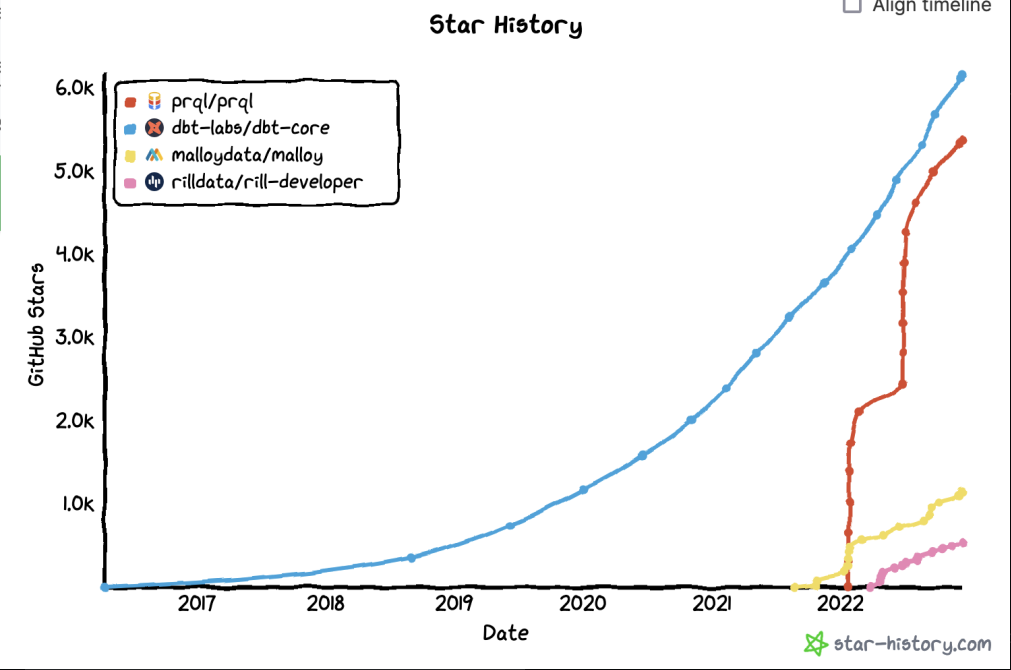